# Visualization

In [2]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import numpy as np
import pandas as pd

## SHAP Plots

In [3]:
# open shap data 
with open('data/classification_results/shap_values_stratifiedCV.pkl', 'rb') as f:
    _shap_values = pickle.load(f)

# sift out shap, y_pred, y_test values
shap_keys = list(_shap_values.keys())[:3]
y_preds_keys = list(_shap_values.keys())[3:6]
y_test_keys = list(_shap_values.keys())[6:9]

shap_values = {k:_shap_values[k] for k in shap_keys}
y_preds = {k[7:]:_shap_values[k] for k in y_preds_keys} # remove 'y_pred_'
y_tests = {k[7:]:_shap_values[k] for k in y_test_keys} # remove 'y_test_'

In [4]:
# open data
# beta correlation source
correlation_beta = pd.read_csv('data/classification_datasets/correlation_source.csv', index_col=0)
correlation_beta = correlation_beta.query('description == "hypnosis"')
correlation_beta = correlation_beta.query('condition.str.contains("experience")').reset_index(drop=True)
col_name = [col for col in correlation_beta.columns if 'beta' in col]
correlation_beta = correlation_beta[col_name]

# gamma power sensor
power_gamma = pd.read_csv('data/classification_datasets/power_sensor.csv', index_col=0)
power_gamma = power_gamma.query('description == "hypnosis"')
power_gamma = power_gamma.query('condition.str.contains("experience")').reset_index(drop=True)
col = [col for col in power_gamma.columns if 'gamma' in col]
power_gamma = power_gamma[col]

### Summary Plots
Summary plots with correctly classified and misclassified groups separated.

In [38]:
# pd.set_option('display.max_rows', 20)
model_name = 'power sensor (gamma)'

values = shap_values[model_name].values

df = pd.DataFrame(data=values, columns=power_gamma.columns)

df['y_pred'] = y_preds[model_name]
df['y_test'] = y_tests[model_name]
df['hit'] = df['y_pred'] == df['y_test']

# # sort values by the mean of each column (last row)
df.sort_values(by=4119, axis=1, ascending=False, inplace=True)

11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


<AxesSubplot:xlabel='value', ylabel='feature'>

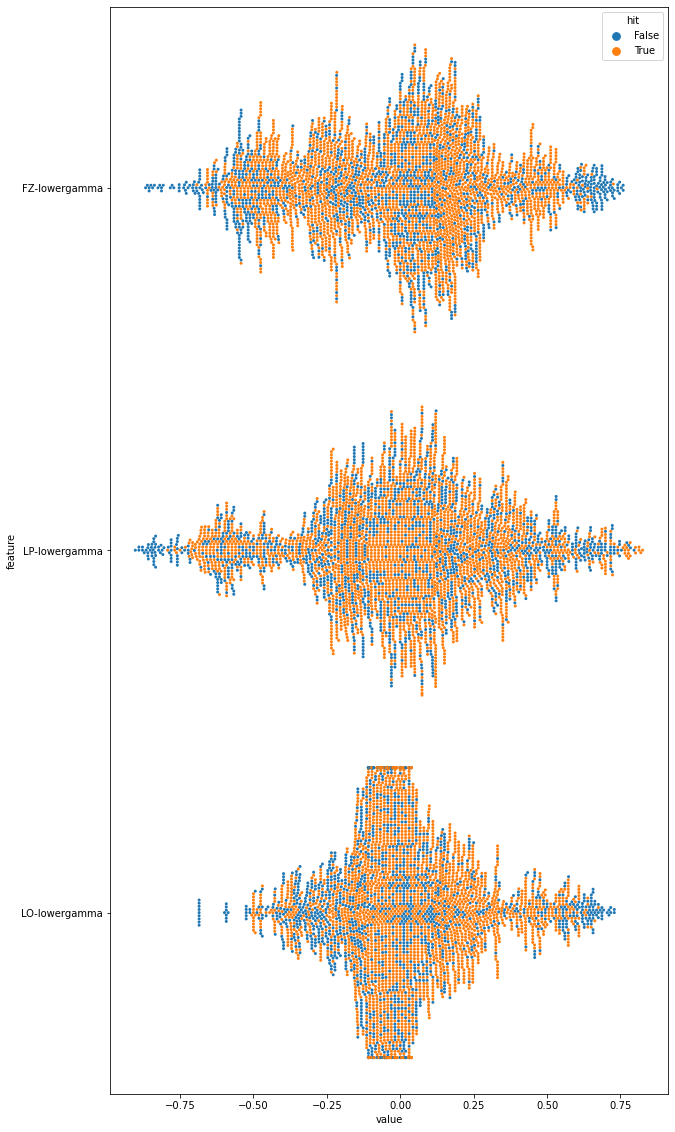

In [46]:
fig, ax = plt.subplots(figsize=(10,20))
df1 = pd.melt(df, id_vars=['hit'], value_vars=df.columns[1:4], var_name='feature')
sns.swarmplot(x='value', y='feature', hue='hit', data=df1, size=3)

<AxesSubplot:xlabel='value', ylabel='feature'>

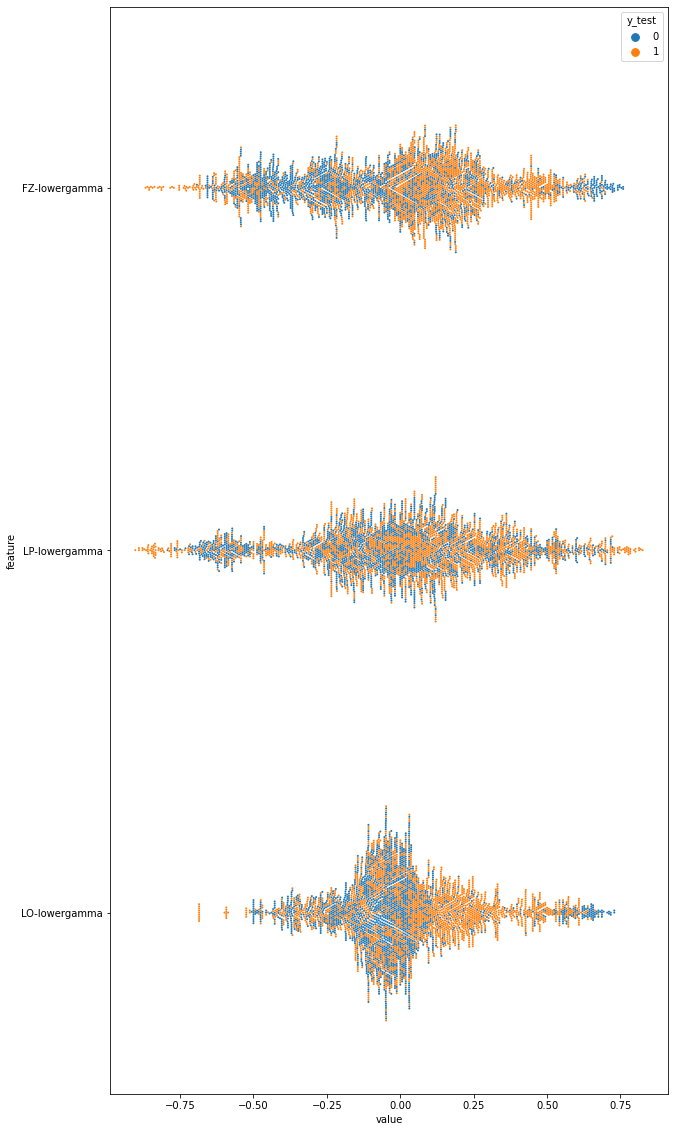

In [48]:
fig, ax = plt.subplots(figsize=(10,20))
df1 = pd.melt(df, id_vars=['y_test'], value_vars=df.columns[1:4], var_name='feature')
sns.swarmplot(x='value', y='feature', hue='y_test', data=df1, size=2)

<AxesSubplot:>

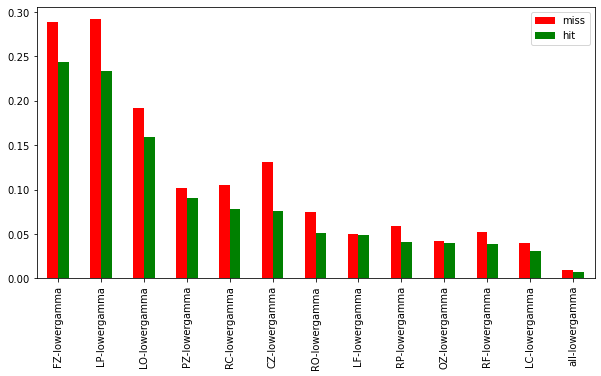

In [117]:
from matplotlib.pyplot import axis


model_name = 'power sensor (gamma)'
data = power_gamma

miss_idx = np.where(y_preds[model_name] != y_tests[model_name])[0]
miss = np.abs(shap_values[model_name].values[miss_idx]).mean(axis=0)
hit = np.abs(np.delete(shap_values[model_name].values, miss_idx, axis=0)).mean(axis=0)

df = pd.DataFrame({'miss':miss,
                   'hit': hit},
                   index=data.columns)

df.sort_values('hit', ascending=False).plot(kind='bar', stacked=False, figsize=(10,5), color=['red', 'green'])

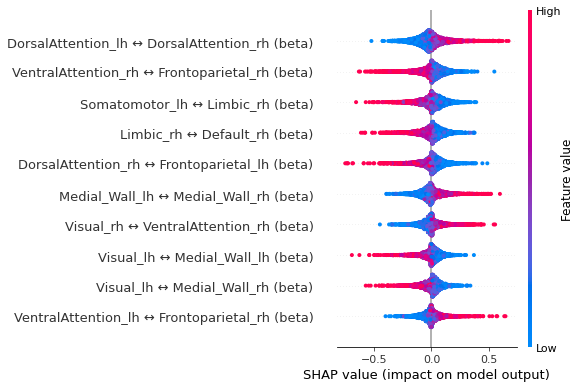

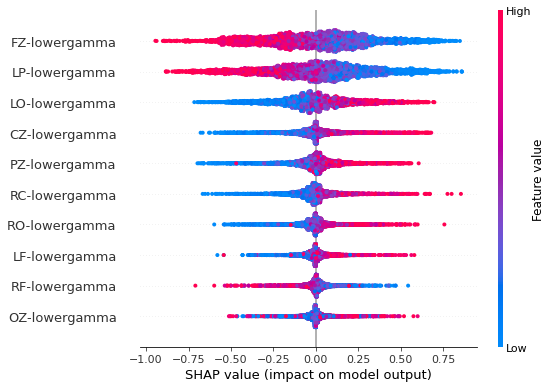

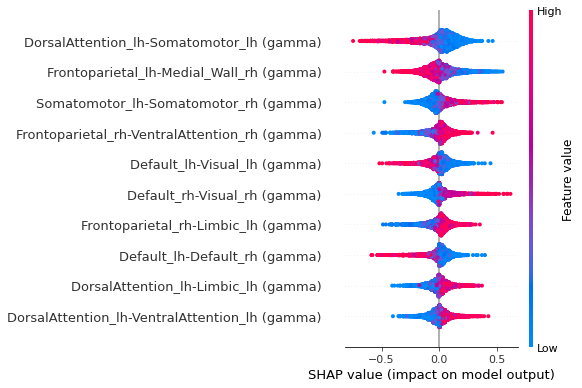

In [4]:
for model_name in shap_values.keys():
    
    shap.summary_plot(shap_values[model_name],  max_display=10)

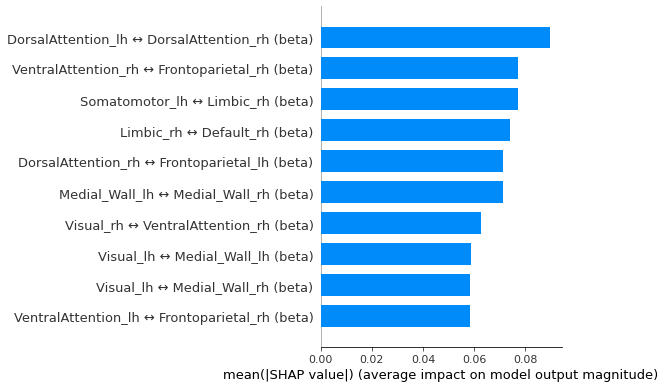

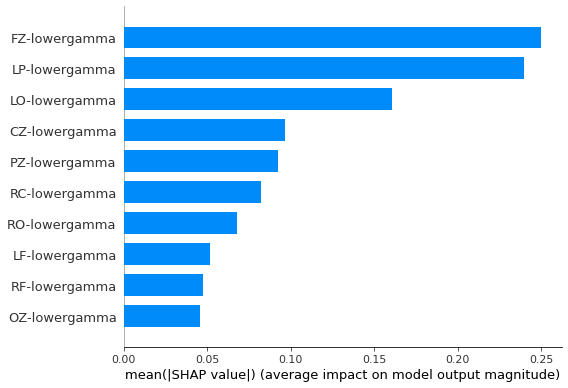

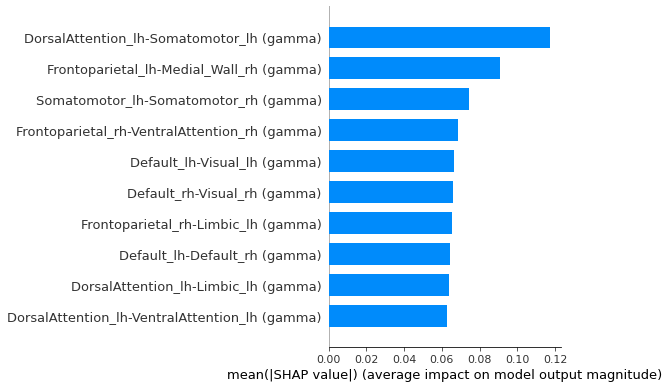

In [5]:
for model_name in shap_values.keys():
    
    shap.summary_plot(shap_values[model_name], plot_type='bar', max_display=10)

### Force Plot

In [17]:
# force plot
shap.initjs()

model_name = 'power sensor (gamma)'
i = 3  # participant index

shap.force_plot(shap_values[model_name].base_values[i],
                shap_values[model_name].values[i],
                shap_values[model_name].data[i])

shap.plots.force is slow for many thousands of rows, try subsampling your data.


# Dependence plot

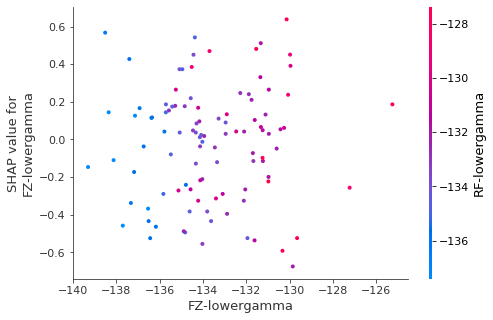

In [7]:
shap.dependence_plot('FZ-lowergamma', shap_values[model_name].values[:103], data)

### Decision Plot
First, we plot the decision tree for the hypnotized participants who were classified as non-hypnotized.

In [8]:
model_name = 'power sensor (gamma)'
i = 7  # participant index

misclassified = np.where(y_tests[model_name] != y_preds[model_name])[0]
misclassified = shap.utils.sample(misclassified, 10, random_state=None)
misclassified

array([ 524, 3994, 2129, 3710, 2783, 3365, 3656, 3836,  210,  286])

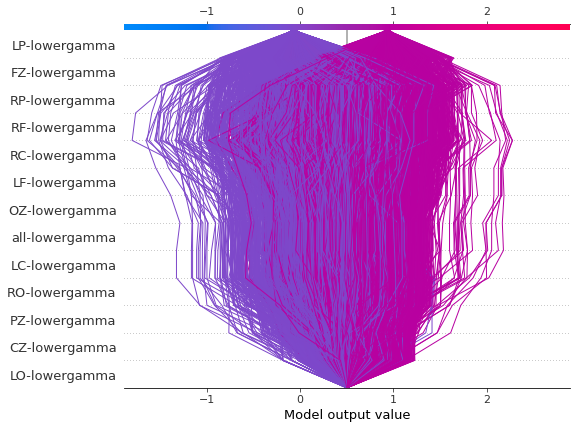

In [9]:
# feature names
df = pd.read_csv('data/classification_datasets/power_sensor.csv')
feature_names = [col for col in df.columns if 'gamma' in col]
i = 2896

# decision plot
# TODO: fix decision plot with different base values #TODO: make decition values identical with stratified CV.
shap.decision_plot(0.5,
                   shap_values[model_name].values,
                   shap_values[model_name].data,
                   feature_order='hclust',
                   feature_names=feature_names,
                   ignore_warnings=True)

In [17]:
df = pd.read_csv('data/classification_datasets/correlation_source.csv')
feature_names = [col for col in df.columns if 'beta' in col]

In [ ]:
model_name = 'correlation source (beta)'
shap.decision_plot(0.57,
                   shap_values[model_name].values,
                   shap_values[model_name].data,
                   feature_display_range=slice(-1, -121, -1),
                   feature_names=feature_names,
                   ignore_warnings=True)

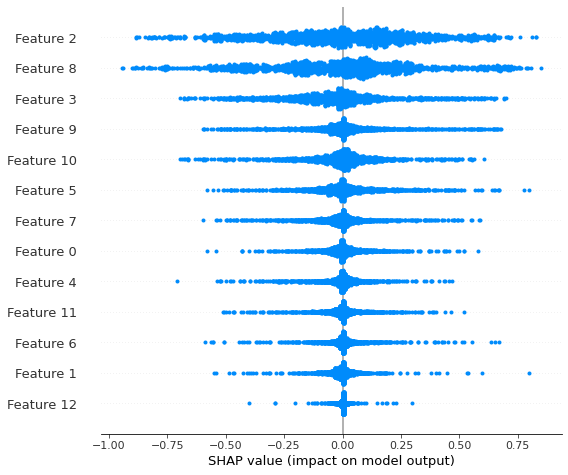

In [6]:
model_name = 'power sensor (gamma)'

misclassified_mask = np.where(y_preds[model_name] != y_tests[model_name])[0]
misclassified_mask_shap = shap_values[model_name].values[misclassified_mask]
shap.summary_plot(misclassified_mask_shap)

## Feature Importance Plots

In [33]:
# open data
with open('data/classification_results/importances.pkl', 'rb') as f:
    importances = pickle.load(f)

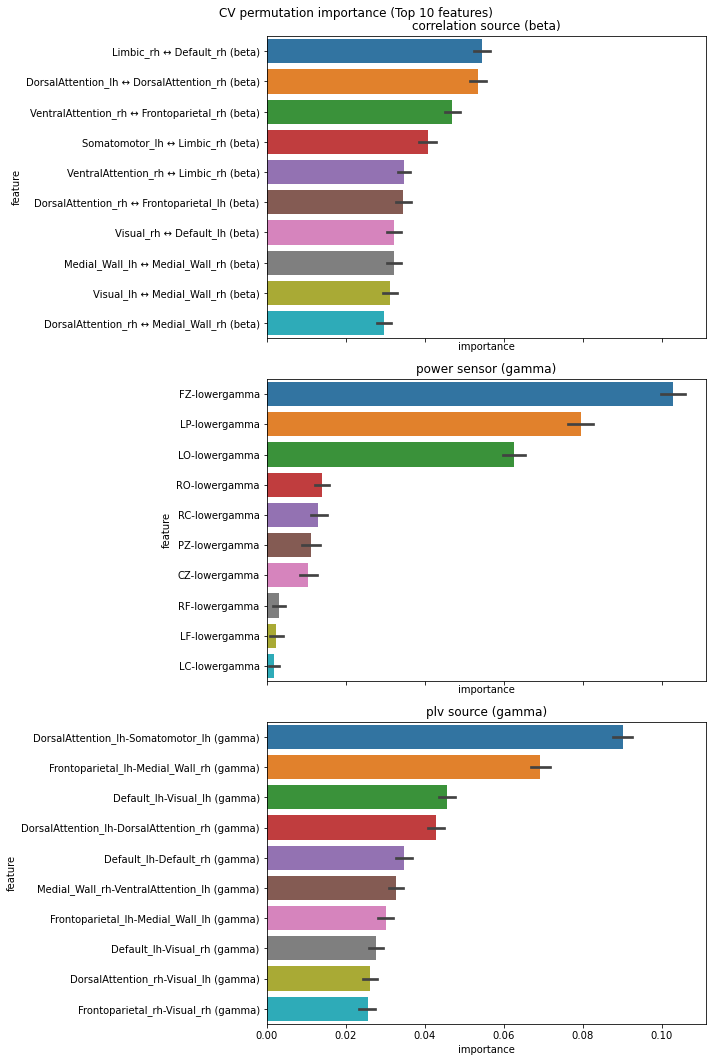

In [34]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

for i, (model_name, model_importances) in enumerate(importances.items()):
    
    order = model_importances.mean(axis=0).sort_values(ascending=False).index
    importances_long = model_importances.melt(var_name='feature', value_name='importance')
    
    sns.barplot(data=importances_long, x='importance', y='feature', order=order[:10], ax=axes[i])
    
    axes[i].set_title(model_name)
plt.suptitle('CV permutation importance (Top 10 features)')
plt.tight_layout()
plt.show()